# planar_arm.ipynb
The place to test equations for the planar arm

## Muscle geometry initialization
The planar arm has 6 muscles and 12 insertion points. The geometry is described by specifying the coordinates for all the insertion points when the arm is at a reference position. This, together with the coordinates of the elbow and the hand fully describe the arm's geometry.

In the reference position the upper arm is aligned with the x axis (e.g. $\theta_1 = 0$) and the forearm is aligned with the y axis ($\theta_2 = \pi/2$).
 

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
## Coordinates for elbow and hand in the reference position
# shoulder is at origin. Length units are meters.
c_shoulder = (0., 0.)
c_elbow = (0.3, 0.)
c_hand = (0.3, 0.3)
## Insertion point coordinates
# biarticular biceps (muscle 1)
i1 = (0., 0.04)  # proximal insertion point
i2 = (0.29, 0.04) # distal insertion point
# anterior deltoid, pectoral (muscle 2)
i3 = (0., 0.04)
i4 = (.1, 0.02)
# posterior deltoid (muscle 3)
i5 = (0., -.04)
i6 = (.1, -0.02)
# biarticular triceps (muscle 4)
i7 = (0., -0.04)
i8 = (.3, -0.03)
# brachialis (muscle 5)
i9 = (0.2, 0.02)
i10 = (0.29, 0.04)
# monoarticular triceps (muscle 6)
i11 = (0.2, -0.02)
i12 =(0.3, -0.03)

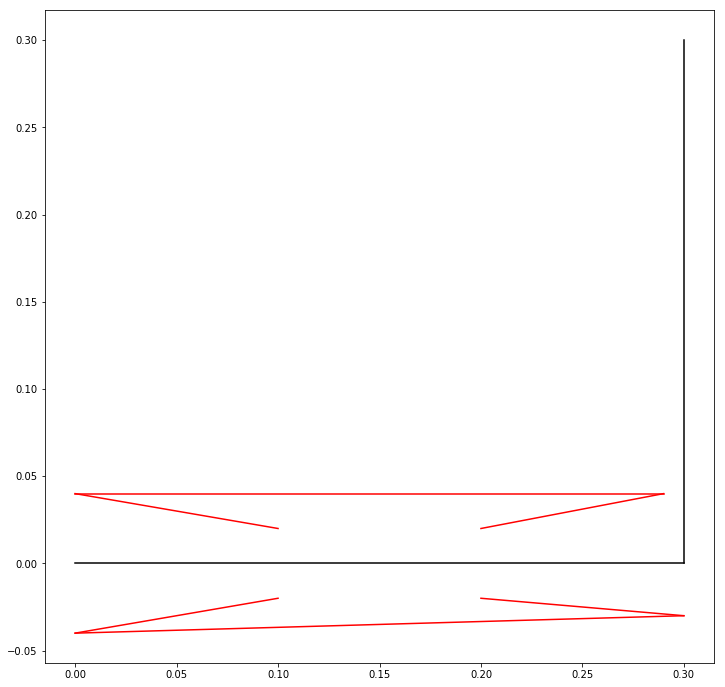

In [3]:
# plot the arm
fig = plt.figure(figsize = (12,12))
# upper arm and forearm
plt.plot([c_shoulder[0], c_elbow[0]], [c_shoulder[1],c_elbow[1]], 'k')
plt.plot([c_elbow[0], c_hand[0]], [c_elbow[1], c_hand[0]], 'k')
# insertion points
points = [i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11,i12]
x_coords = [i[0] for i in points]
y_coords = [i[1] for i in points]
for idx in range(0,12,2):
    plt.plot(x_coords[idx:idx+2], y_coords[idx:idx+2], 'r')
plt.show()

## Torque produced by each muscle given its tension
For each muscle, given a Tension $T$, produce the torque $\tau$ it produces with respect to either the shoulder or the elbow axis.

In [4]:
T = 1.

def shoulder_torque(i_prox, i_dist, T):
    """ Obtain the torque produced by a muscle wrt the shoulder joint.
    
        Args:
            i_prox : coordinates of proximal insertion point (tuple)
            i_dist : coordinates of distal insertion point (tuple)
            T : muscle tension
        Returns:
            float
    """
    v = np.array([i_prox[0] - i_dist[0], i_prox[1] - i_dist[1]])
    v_norm = (sum(v*v))**(1./2.)
    F = (T/v_norm) * v
    tau = i_dist[0] * F[1] - i_dist[1] * F[0]
    return tau

def elbow_torque(i_prox, i_dist, T):
    """ Obtain the torque produced by a muscle wrt the shoulder joint.
    
        Args:
            i_prox : coordinates of proximal insertion point (tuple)
            i_dist : coordinates of distal insertion point (tuple)
            T : muscle tension
        Returns:
            float
    """
    v = np.array([i_prox[0] - i_dist[0], i_prox[1] - i_dist[1]])
    v_norm = (sum(v*v))**(1./2.)
    F = (T/v_norm) * v
    tau = (i_dist[0]-c_elbow[0]) * F[1] - (i_dist[1]-c_elbow[1]) * F[0]
    return tau

#ip = [np.array(p) for p in points]
# muscle 1 wrt shouler
tau1s = shoulder_torque(i1, i2, T)
# muscle 1 wrt elbow
tau1e = elbow_torque(i1, i2, T)
# muscle 2 wrt shoulder
tau2s = shoulder_torque(i3, i4, T)
# muscle 3 wrt shoulder
tau3s = shoulder_torque(i5, i6, T)
# muscle 4 wrt shouler
tau4s = shoulder_torque(i7, i8, T)
# muscle 4 wrt elbow
tau4e = elbow_torque(i7, i8, T)
# muscle 5 wrt elbow
tau5e = elbow_torque(i9, i10, T)
# muscle 6 wrt elbow
tau6e = elbow_torque(i11, i12, T)

tau_shoulder = tau1s + tau2s + tau3s + tau4s
tau_elbow = tau1e + tau4e + tau5e + tau6e

In [5]:
from draculab import *
params = {'l0': 0.9,
          's' : 0.05,
          'g1': 1.,
          'g2': 0.5,
          'g3': 0.5,
          'dt': 0.01,
          'p1': [0.,0.],
          'p2': [.2,0.] }
musk = spring_muscle(params)

In [6]:
for pos in [.2+0.03*i for i in range(15)]:
    musk.update((0.,0.),(pos,0), 1., 1., 1.)

In [7]:
musk.T

1.022

In [8]:
print(musk.l_lpf_fast)
print(musk.l_lpf_mid)

0.6025407133118306
0.4050918153486639


In [9]:
musk.v

2.9617334694475

In [10]:
abs(-np.sqrt(np.arctan(1)*4)**2)

3.1415926535897927

## Testing an instance of the `planar_arm` class

In [1]:
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
%matplotlib widget

In [2]:
net_params = {'min_delay':0.01,
              'min_buff_size': 10 }

arm_params = {'type': plant_models.planar_arm,
          'mass1': 1.,
          'mass2': 1.,
          'init_q1': 0.,
          'init_q2': 0., #np.pi/4.,
          'init_q1p': 0.,
          'init_q2p': 0.,
          'g': 0.0,
          'mu1': 0.01,
          'mu2': 0.01
         }
track_params = {'type': unit_types.source,
                'init_val': 0.,
                'function' : lambda x: 0.}
net = network(net_params)
arm_id = net.create(1, arm_params)
# create source units to track the insertion points
ipx_track = net.create(12, track_params) # x coordinates
ipy_track = net.create(12, track_params) # y coordinates
# create source units to track the tensions
ten_track = net.create(6, track_params)

def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]

def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]

def create_tentracker(arm_id, idx):
    return lambda t: net.plants[arm_id].muscles[idx].T

for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(arm_id, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(arm_id, idx))
for idx, uid in enumerate(ten_track):
    net.units[uid].set_function(create_tentracker(arm_id, idx))

In [3]:
sim_time = 100. # simulation time
start_time = time.time()
sim_dat = net.flat_run(sim_time)
arm_activs = np.array(sim_dat[2][arm_id])
print('Execution time: %s seconds' % (time.time() - start_time))

Execution time: 12.113058805465698 seconds


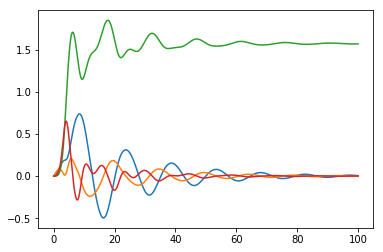

In [4]:
# plotting the state variables
fig = plt.figure()
plt.plot(sim_dat[0], arm_activs)
plt.show()

In [5]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin

# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(sim_dat[1])
ipx = acts[ipx_track]
ipy = acts[ipy_track]
ten = acts[ten_track] # muscle tensions
# coordinates of hand and elbow
l1 = net.plants[arm_id].l_arm
l2 = net.plants[arm_id].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(10,10))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
ten = (ten / 2.) + 0.5
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*0.01
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    return line, points, muls_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 2), init_func=init, blit=True, interval=10)

plt.show()

FigureCanvasNbAgg()

In [6]:
# plotting the tensions
ten = acts[ten_track]
fig = plt.figure()
plt.plot(sim_dat[0], np.transpose(ten))
plt.show()

FigureCanvasNbAgg()

In [16]:
ten.shape

(6, 5000)